# Scenario 3 subtask 1: Estimate the True Number of Infections

# Clean Version

**Background:** 10/2020 - 1/2021 in Greater Boston area. Predicting cases from wastewater potentially reports closer to the truth than testing.

## **TASK 1:** Replicate the fitting exercise (A) in Section 3.2 <br>
paper: https://doi.org/10.1016/j.scitotenv.2022.159326.

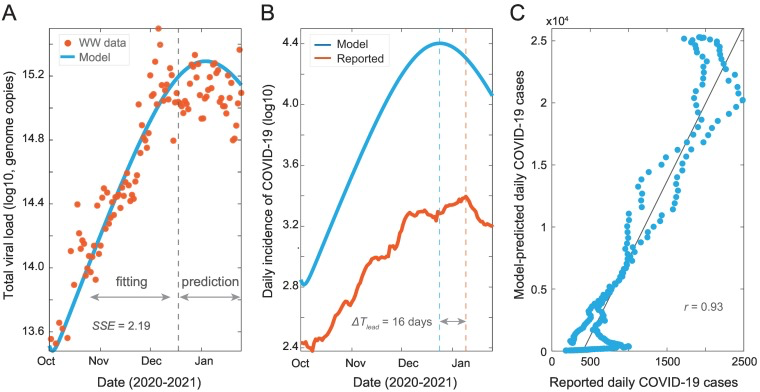

**Specifications:**
1. SEIR-V model
2. Fit $\lambda$, $\alpha$, and E(0).
3. Data found in supplementary materials
4. Simplify wherever necessary (e.g. fixed $\beta$)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyciemss.visuals.plots as plots
from pyciemss.PetriNetODE.interfaces import (
    load_and_sample_petri_model,
    load_and_calibrate_and_sample_petri_model,
    load_petri_model,
    setup_petri_model,
    sample
)
from pyciemss.utils.interface_utils import convert_to_output_format
from pyciemss.utils import get_tspan

from mira.sources.askenet.petrinet import model_from_url
from mira.metamodel import Distribution
from mira.modeling.askenet.petrinet import AskeNetPetriNetModel
from mira.modeling import Model
import urllib.request, json
import requests

### Plot the Data:

V
time              
0     3.424864e+13
1     7.482611e+13
2     1.107730e+14
3     1.455132e+14
4     1.789461e+14
...            ...
221   1.256720e+17
222   1.257698e+17
223   1.258096e+17
224   1.258676e+17
225   1.259472e+17

[226 rows x 1 columns]

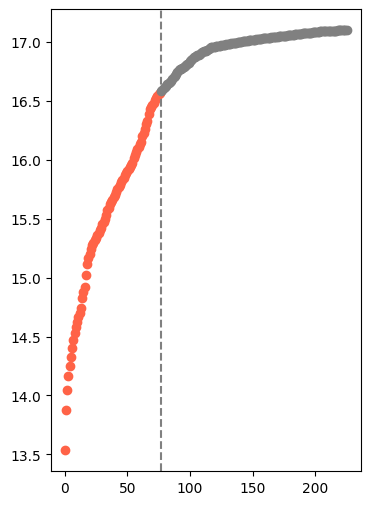

In [2]:
# Load Data
## This uses the cumsum() of the raw data
data_train = pd.read_csv('./data/processed_dataset_train.csv', index_col="time")
data_test  = pd.read_csv('./data/processed_dataset_test.csv', index_col="time")
data_whole = pd.read_csv('./data/processed_dataset.csv', index_col="time")
display(data_whole)

# Plot
plt.figure(figsize=(4,6))
plt.scatter(data_train.index, np.log10(data_train.V), color='tomato')
plt.scatter(data_test.index, np.log10(data_test.V), color='grey')
plt.axvline(77, linestyle='dashed', color='grey')

### Simulate using the best fit parameters

$\beta = 4.49\times 10^7$ viral RNA per g.

Best fit parameters: $\lambda =9.66\times 10^{-8}\frac{1}{day\cdot person}, \alpha = 249 g, \gamma = 0.08, \text{ and } E(0) = 11 \text{ people.}$



In [3]:
from mira.sources.askenet import model_from_json_file


best_fit_model = model_from_json_file('ES3_detection_log10V.json')
best_fit_model.initials['E'].value = 11
S, E, I = best_fit_model.initials['S'].value, best_fit_model.initials['E'].value, best_fit_model.initials['I'].value

best_fit_model.parameters['lambda'].value = 9.66e-8*(S + E + I)
#best_fit_model.parameters['lambda'].distribution = Distribution(type="Uniform1", parameters={"minimum": 0.2, "maximum":0.21})
best_fit_model.parameters['gamma'].value = 0.08
best_fit_model.parameters['beta'].value = 44852600
best_fit_model.parameters['delta'].value = 0.125

best_fit_model.parameters['k'].value = 0.333
#best_fit_model.parameters['k'].distribution = Distribution(type="Uniform1", parameters={"minimum": 0.25, "maximum":0.5})

best_fit_model.parameters['alpha'].value = 249 
best_fit_model.parameters['alpha'].distribution = None#distribution=Distribution(type='Uniform1', parameters={'minimum': 50.0, 'maximum': 400.0})

In [4]:
best_fit_model.parameters

{'lambda': Parameter(name='lambda', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1/(day*person)), value=0.2221810626, distribution=None),
 'k': Parameter(name='k', display_name=None, description=None, identifiers={}, context={}, units=None, value=0.333, distribution=None),
 'delta': Parameter(name='delta', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1/day), value=0.125, distribution=None),
 'alpha': Parameter(name='alpha', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=gram), value=249, distribution=None),
 'beta': Parameter(name='beta', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=virus/gram), value=44852600, distribution=None),
 'gamma': Parameter(name='gamma', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1/day), value=0.08, distribution=None)}

In [5]:
num_samples = 1
start_time = 0
end_time = 226 # between 10/02/2020 and 01/25/2021
num_timepoints = (end_time-start_time)*10 + 1
timepoints = list(get_tspan(start_time, end_time, num_timepoints).detach().numpy())

prior_samples = load_and_sample_petri_model(
        best_fit_model, num_samples, timepoints=timepoints,
    visual_options={"title": "3_base", "keep":["V_sol"]}, time_unit="days")
prior_samples['data']

ERROR:root:
                ###############################

                There was an exception in pyciemss
                
                Error occured in function: load_and_sample_petri_model

                Function docs : 
    Load a petri net from a file, compile it into a probabilistic program, and sample from it.

    Args:
        petri_model_or_path: Union[str, mira.metamodel.TemplateModel, mira.modeling.Model]
            - A path to a petri net file, or a petri net object.
            - This path can be a URL or a local path to a mira model or AMR model.
            - Alternatively, this can be a mira template model directly.
        num_samples: int
            - The number of samples to draw from the model.
        timepoints: [Iterable[float]]
            - The timepoints to simulate the model from. Backcasting and/or forecasting is reflected in the choice of timepoints.
        interventions: Optional[Iterable[Tuple[float, str, float]]]
            - A list of int

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

# Plot the uncalibrated trajectories

In [ ]:
schema = plots.trajectories(pd.DataFrame(prior_samples["data"]), keep=["V_sol"],
                            markers={"Training": 77},
                           points=data_whole.reset_index(drop=True).rename(columns={"V":"V_data"})
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

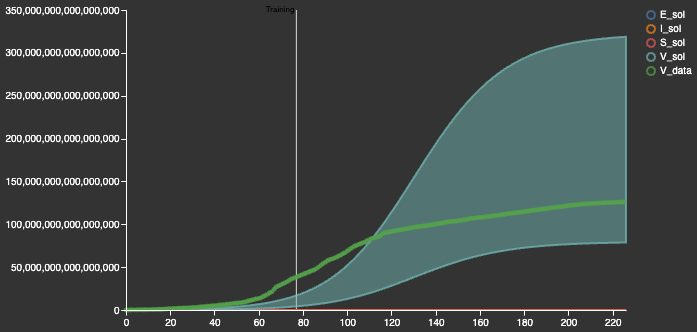

### Calibrate:

In [ ]:
calibrated_samples = load_and_calibrate_and_sample_petri_model(
            template_model,
            './data/processed_dataset_train.csv',
            50,
            timepoints=timepoints,
            verbose=True,
            num_iterations=200,
            visual_options={"title": "3_base", "keep":["V_sol"]}, time_unit="days")

In [ ]:
schema = plots.trajectories(pd.DataFrame(calibrated_samples["data"]), keep="V_sol",
                            markers={"Training": 77},
                            points=data_whole.reset_index(drop=True).rename(columns={"V":"V_data"}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

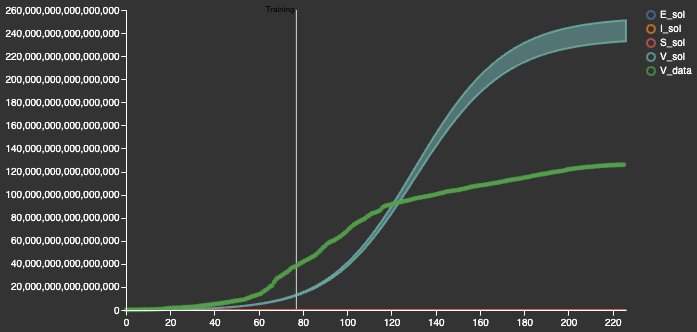

### Mimic the paper figure

In [ ]:
# TODO

## **TASK 3:** Repeat with uncertainty over the paper's parameters.

In [ ]:
#SEIV_model_url  = "https://raw.githubusercontent.com/indralab/mira/hackathon2/notebooks/evaluation_2023.07/eval_scenario3_base.json"
from mira.sources.askenet import model_from_json_file
SEIVCDU_model_json = 'ES3_detection_log10V.json'
uncertain_model = model_from_json_file('ES3_detection_log10V.json')
uncertain_model.initials['E'].value = 1000
S, E, I = uncertain_model.initials['S'].value, uncertain_model.initials['E'].value, uncertain_model.initials['I'].value

uncertain_model.parameters['lambda'].value = 9.66e-8*(S + E + I)
uncertain_model.parameters['lambda'].distribution = Distribution(type="Uniform1", parameters={"minimum": 0.1, "maximum":0.21})
uncertain_model.parameters['gamma'].value = 0.08
uncertain_model.parameters['gamma'].distribution = Distribution(type="Uniform1", parameters={"minimum": 0.05, "maximum":0.15})
uncertain_model.parameters['beta'].value = 44852600
uncertain_model.parameters['delta'].value = 0.125

uncertain_model.parameters['k'].value = 0.333
uncertain_model.parameters['k'].distribution = Distribution(type="Uniform1", parameters={"minimum": 0.25, "maximum":0.5})

uncertain_model.parameters['alpha'].value = 249 
uncertain_model.parameters['alpha'].distribution = distribution=Distribution(type='Uniform1', parameters={'minimum': 50.0, 'maximum': 400.0})

In [ ]:
num_samples = 100
start_time = 0
end_time = 226 # between 10/02/2020 and 01/25/2021
num_timepoints = (end_time-start_time)*10 + 1
timepoints = list(get_tspan(start_time, end_time, num_timepoints).detach().numpy())

prior_samples = load_and_sample_petri_model(
        uncertain_model, num_samples, timepoints=timepoints,
    visual_options={"title": "3_base", "keep":["V_sol"]}, time_unit="days")

In [ ]:
prior_samples['data']

In [ ]:
schema = plots.trajectories(pd.DataFrame(prior_samples["data"]), keep="V_sol",
                            markers={"Training": 77},
                            points=data_whole.reset_index(drop=True).rename(columns={"V":"V_data"}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

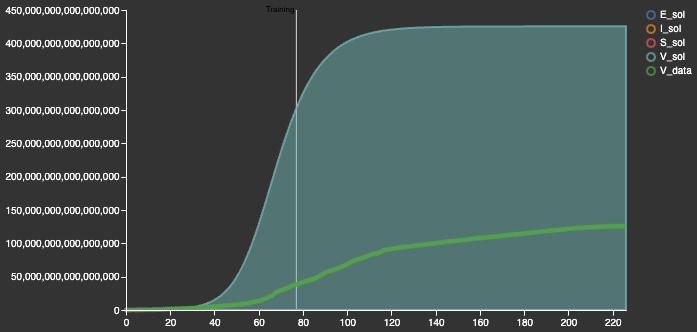

### Calibrate:

In [ ]:
calibrated_samples = load_and_calibrate_and_sample_petri_model(
            uncertain_model,
            './data/processed_dataset_train.csv',
            100,
            timepoints=timepoints,
            num_iterations=200,
            verbose=True,
            visual_options={"title": "3_base", "keep":["V_sol"]}, time_unit="days")

In [ ]:
schema = plots.trajectories(pd.DataFrame(calibrated_samples["data"]), keep="V_sol",
                            markers={"Training": 77},
                            points=data_whole.reset_index(drop=True).rename(columns={"V":"V_data"}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

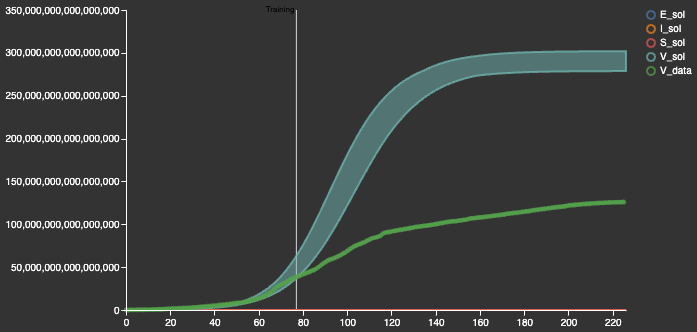

In [ ]:
# View what values the calibration landed on
display(calibrated_samples["data"])

In [ ]:
calibrated_samples['data'].to_csv('data/calibrated_samples_from_wastewater.csv', index=False)

**BONUS:** Use temperature data during fitting to replicate figure 3A. Prove that it improves fit.
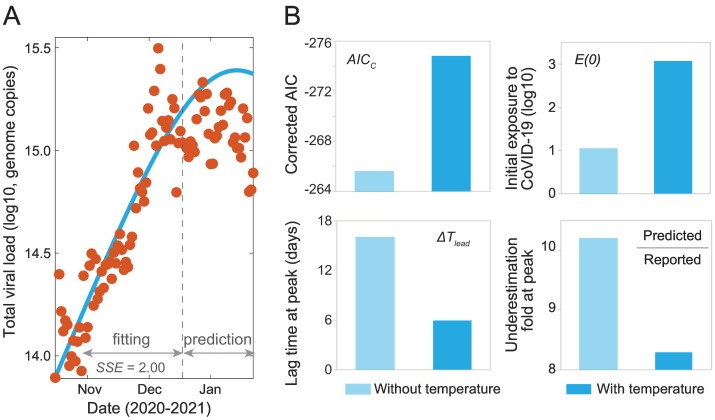

In [ ]:
# TODO